<a href="https://colab.research.google.com/github/henryHyun/KNU/blob/main/%E1%84%8C%E1%85%AE%E1%86%BC%E1%84%80%E1%85%A1%E1%86%AB%E1%84%80%E1%85%A9%E1%84%89%E1%85%A1_%E1%84%83%E1%85%A2%E1%84%8E%E1%85%A6%E1%84%80%E1%85%AA%E1%84%8C%E1%85%A6_%ED%98%84%EB%8F%99%ED%98%B8_201910182.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 중간고사 대체 과제 (Due: 10월 29일 금요일 오후 11시 59분)

아래 코드는 statsmodel 패키지 내 Star98 데이터베이스를 다운로드 받아 이를 각각 df_festures, df_target DataFrame 객체로 저장하는 코드입니다. 

In [43]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
sp.init_printing(use_latex='mathjax')
import copy
import time

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import patsy
import pandas as pd
import seaborn as sns
from scipy import stats
plt.style.use(["seaborn-whitegrid"])
import multiprocessing as mp
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz

df_features = sm.datasets.star98.load_pandas().exog
df_target   = sm.datasets.star98.load_pandas().endog

In [3]:
df_features.head()

,LOWINC,PERASIAN,PERBLACK,PERHISP,PERMINTE,AVYRSEXP,AVSALK,PERSPENK,PTRATIO,PCTAF,PCTCHRT,PCTYRRND,PERMINTE_AVYRSEXP,PERMINTE_AVSAL,AVYRSEXP_AVSAL,PERSPEN_PTRATIO,PERSPEN_PCTAF,PTRATIO_PCTAF,PERMINTE_AVYRSEXP_AVSAL,PERSPEN_PTRATIO_PCTAF
0,34.39730,23.299300,14.235280,11.411120,15.91837,14.70646,59.15732,4.445207,21.71025,57.03276,0.0,22.222220,234.102872,941.68811,869.9948,96.50656,253.52242,1238.1955,13848.8985,5504.0352
1,17.36507,29.328380,8.234897,9.314884,13.63636,16.08324,59.50397,5.267598,20.44278,64.62264,0.0,0.000000,219.316851,811.41756,957.0166,107.68435,340.40609,1321.0664,13050.2233,6958.8468
2,32.64324,9.226386,42.406310,13.543720,28.83436,14.59559,60.56992,5.482922,18.95419,53.94191,0.0,0.000000,420.854496,1746.49488,884.0537,103.92435,295.75929,1022.4252,25491.1232,5605.8777
3,11.90953,13.883090,3.796973,11.443110,11.11111,14.38939,58.33411,4.165093,21.63539,49.06103,0.0,7.142857,159.882095,648.15671,839.3923,90.11341,204.34375,1061.4545,9326.5797,4421.0568
4,36.88889,12.187500,76.875000,7.604167,43.58974,13.90568,63.15364,4.324902,18.77984,52.38095,0.0,0.000000,606.144976,2752.85075,878.1943,81.22097,226.54248,983.7059,38280.2616,4254.4314


In [4]:
df_target.head()

,NABOVE,NBELOW
0,452.0,355.0
1,144.0,40.0
2,337.0,234.0
3,395.0,178.0
4,8.0,57.0


위 데이터는 1998년 미국 캘리포니아 교육부에서 초중고등학생들을 대상으로 (2nd ~ 11th grade) 실시한 지역(county)별 수학 과목 학력평가 시험 결과 및 각 지역 내 학업 성적과 관련이 있을 수 있는 변수들을 조사한 결과를 담고 있습니다. 각 feature들에 대한 설명은 다음과 같습니다. (자세한 설명은 [여기를](https://www.statsmodels.org/stable/datasets/generated/star98.html) 참조)

*   df_target 내에서:
>* **NABOVE**: 해당 지역 내 전국 성적 중앙값을 넘은 점수를 받은 학생들의 수.
>* **NBELOW**: 해당 지역 내 전국 성적 중앙값에 미치지 못하는 점수를 받은 학생들의 수 (따라서, NABOVE + NBELOW = 해당 지역 총 학생 수).

* df_features 내에서:
>* **LOWINC**: 해당 지역 내 저소득층 학생 비율.
>* **PERASIAN**: 해당 지역 내 아시아계 학생 비율.
>* **PERBLACK**: 해당 지역 내 흑인 학생 비율.
>* **PERHISP**: 해당 지역 내 히스패닉 학생 비율.
>* **PERMINTE**: 해당 지역 내 소수인종 교사 비율.
>* **AVYRSEXP**: 해당 지역 내 교사 평균 근속년수.
>* **AVSALK**: 해당 지역 내 교사 평균 연봉 (단위: 1000달러). 
>* **PERSPENK**: 해당 지역 내 학생 1명당 교육 예산 지출 (단위: 1000달러). 
>* **PTRATIO**: 해당 지역 내 교사 1명 당 학생 수.
>* **PCTAF**: 해당 지역 내 캘리포니아 주립대에서 제공하는 prep course(물리, 화학, 생물 등의 과학 과목을 대학교에서 미리 배울 수 있는 제도)를 수강하는 학생 비율. 
>* **PCTCHRT**: 해당 지역 내 차터 스쿨 (https://ko.wikipedia.org/wiki/차터_스쿨) 비율.
>* **PCTYRRND**: 해당 지역 내 year-round 스쿨 (https://www.edweek.org/leadership/year-round-schooling-explained/2015/12) 비율. 
>* **PERMINTE_AVYRSEXP** = PERMINTE * AVYRSEXP.
>* **PEMINTE_AVSAL** = PERMINTE * AVSALK. 
>* **AVYRSEXP_AVSAL** = AVYRSEXP * AVSALK. 
>* **PERSPEN_PTRATIO** = PERSPENK * PTRATIO.
>* **PERSPEN_PCTAF** = PERSPENK * PCTAF.
>* **PTRATIO_PCTAF** = PTRATIO * PCTAF. 
>* **PERMINTE_AVTRSEXP_AVSAL** = PERMINTE * AVYRSEXP * AVSALK. 

## 문제: 
위 자료들을 이용하여, 학생들의 학업 성적과 다른 변수들 사이의 관계를 설명하는 통계적 모델을 만들고, 이를 통해 학생들의 성적에 중요한 영향을 끼치는 요인들에 어떤 것들이 있는지를 통계 모델 분석 및 시각화를 근거로 서술하세요.  

In [1]:
# 각 열의 이름을 한글로 변환 
names = {
    'LOWINC' : '저소득층 학생비율',
    'PERASIAN' : '아시아계 학생비율',
    'PERBLACK': '흑인 학생비율',
    'PERHISP' : '히스패닉 학생비율',
    'PERMINTE' : '소수인종 교사비율',
    'AVYRSEXP' : '교사 평균근속년수',
    'AVSALK' : '교사 평균연봉',
    'PERSPENK' : '학생 1명당 교육예산 지출',
    'PTRATIO' : '교사 1명 당 학생수',
    'PCTAF' : 'prep course 수강학생 비율',
    'PCTCHRT' : '차터스쿨 비율',
    'PCTYRRND' : 'year-round 스쿨 비율'
}

names2 = {
    'NABOVE' : '평균 초과 학생수',
    'NBELOW' : '평균 미만 학생수'
}

In [46]:
# rename 으로 이름 변환 inplace 는 변환값을 적용시키는 함수
df_features.rename(columns = names, inplace = True)
df_features.head()

,저소득층 학생비율,아시아계 학생비율,흑인 학생비율,히스패닉 학생비율,소수인종 교사비율,교사 평균근속년수,교사 평균연봉,학생 1명당 교육예산 지출,교사 1명 당 학생수,prep course 수강학생 비율,차터스쿨 비율,year-round 스쿨 비율,PERMINTE_AVYRSEXP,PERMINTE_AVSAL,AVYRSEXP_AVSAL,PERSPEN_PTRATIO,PERSPEN_PCTAF,PTRATIO_PCTAF,PERMINTE_AVYRSEXP_AVSAL,PERSPEN_PTRATIO_PCTAF
0,34.39730,23.299300,14.235280,11.411120,15.91837,14.70646,59.15732,4.445207,21.71025,57.03276,0.0,22.222220,234.102872,941.68811,869.9948,96.50656,253.52242,1238.1955,13848.8985,5504.0352
1,17.36507,29.328380,8.234897,9.314884,13.63636,16.08324,59.50397,5.267598,20.44278,64.62264,0.0,0.000000,219.316851,811.41756,957.0166,107.68435,340.40609,1321.0664,13050.2233,6958.8468
2,32.64324,9.226386,42.406310,13.543720,28.83436,14.59559,60.56992,5.482922,18.95419,53.94191,0.0,0.000000,420.854496,1746.49488,884.0537,103.92435,295.75929,1022.4252,25491.1232,5605.8777
3,11.90953,13.883090,3.796973,11.443110,11.11111,14.38939,58.33411,4.165093,21.63539,49.06103,0.0,7.142857,159.882095,648.15671,839.3923,90.11341,204.34375,1061.4545,9326.5797,4421.0568
4,36.88889,12.187500,76.875000,7.604167,43.58974,13.90568,63.15364,4.324902,18.77984,52.38095,0.0,0.000000,606.144976,2752.85075,878.1943,81.22097,226.54248,983.7059,38280.2616,4254.4314


In [12]:
# iloc으로 행번호 기준으로 데이터 뽑아보기 
df_x = df_features.iloc[:, :12]
df_x

,저소득층 학생비율,아시아계 학생비율,흑인 학생비율,히스패닉 학생비율,소수인종 교사비율,교사 평균근속년수,교사 평균연봉,학생 1명당 교육예산 지출,교사 1명 당 학생수,prep course 수강학생 비율,차터스쿨 비율,year-round 스쿨 비율
0,34.39730,23.299300,14.235280,11.411120,15.918370,14.70646,59.15732,4.445207,21.71025,57.03276,0.0,22.222220
1,17.36507,29.328380,8.234897,9.314884,13.636360,16.08324,59.50397,5.267598,20.44278,64.62264,0.0,0.000000
2,32.64324,9.226386,42.406310,13.543720,28.834360,14.59559,60.56992,5.482922,18.95419,53.94191,0.0,0.000000
3,11.90953,13.883090,3.796973,11.443110,11.111110,14.38939,58.33411,4.165093,21.63539,49.06103,0.0,7.142857
4,36.88889,12.187500,76.875000,7.604167,43.589740,13.90568,63.15364,4.324902,18.77984,52.38095,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
298,62.23968,13.820860,3.956157,32.128790,15.884480,13.27089,52.88133,4.324174,20.98711,8.00000,0.0,18.181820
299,46.16188,1.150575,0.800400,45.622810,13.333330,11.80714,48.42615,3.945069,19.85830,53.77358,0.0,0.000000
300,43.41431,3.648564,1.541204,46.319980,21.377670,14.40468,53.79616,3.845481,22.70884,29.89247,0.0,6.666667
301,70.62104,20.461720,2.989345,17.423050,11.032860,16.56420,61.70566,3.970984,24.88647,15.14286,0.0,13.636360


In [7]:
# 정규화 함수 
def normalize(column):
  column = np.array(column)
  mean = column.mean()
  #mean = 평균 
  std  = column.std()
  #std = 표준편차
  column = column - mean
  normalized_column = column / std
  return normalized_column

In [13]:
# 모든 열에 대해 정규화 
for key in df_x.keys():
    df_x[key] = normalize(df_x[key])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
#타겟 값의 이름을 한글로 변환
df_target.rename(columns = names2, inplace = True)
df_target.head()

,평균 초과 학생수,평균 미만 학생수,total
0,0.560099,0.439901,807.0
1,0.782609,0.217391,184.0
2,0.590193,0.409807,571.0
3,0.689354,0.310646,573.0
4,0.123077,0.876923,65.0


In [19]:
# 백분위를 구하기 위해서 총합 으로 나눠줌(이미 정규화 과정이 진행되어있는 상태)
df_y = df_target.iloc[:, :]
df_y['total'] = df_y['평균 미만 학생수'] + df_y['평균 초과 학생수'] 
df_y['평균 초과 학생수'] = df_y['평균 초과 학생수'] / df_y['total']
df_y['평균 미만 학생수'] = df_y['평균 미만 학생수'] / df_y['total']
df_y.head()

,평균 초과 학생수,평균 미만 학생수,total
0,0.560099,0.439901,1.0
1,0.782609,0.217391,1.0
2,0.590193,0.409807,1.0
3,0.689354,0.310646,1.0
4,0.123077,0.876923,1.0


In [22]:
#평균을 초과하는 학생수가 많은 행에 대해 True 혹은 False 적용 
df_y['label'] = df_y['평균 초과 학생수']  > df_y['평균 미만 학생수']
df_y

,평균 초과 학생수,평균 미만 학생수,total,label
0,0.560099,0.439901,1.0,True
1,0.782609,0.217391,1.0,True
2,0.590193,0.409807,1.0,True
3,0.689354,0.310646,1.0,True
4,0.123077,0.876923,1.0,False
...,...,...,...,...
298,0.280702,0.719298,1.0,False
299,0.240260,0.759740,1.0,False
300,0.349580,0.650420,1.0,False
301,0.280677,0.719323,1.0,False


In [23]:
# 람다식으로 True에는 1 False 에는 0 적용 
df_y['label'] = df_y['label'].apply(lambda x : 1 if x == True else 0)
df_y

,평균 초과 학생수,평균 미만 학생수,total,label
0,0.560099,0.439901,1.0,1
1,0.782609,0.217391,1.0,1
2,0.590193,0.409807,1.0,1
3,0.689354,0.310646,1.0,1
4,0.123077,0.876923,1.0,0
...,...,...,...,...
298,0.280702,0.719298,1.0,0
299,0.240260,0.759740,1.0,0
300,0.349580,0.650420,1.0,0
301,0.280677,0.719323,1.0,0


In [47]:
# numpy 배열로 변환 후 크기 출력 
X, Y = np.array(df_x), np.array(df_y.iloc[:, -1])
print(X.shape, Y.shape)

(303, 12) (303,)


In [25]:
#훈련모델생성 및 크기 출력 
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 123)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(242, 12)
(242,)
(61, 12)
(61,)


In [35]:
# 결정트리 모델 생성, 깊이는 5
model = DecisionTreeClassifier(max_depth = 5 )
model 

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [40]:
scores = cross_val_score(estimator = model,
                        X = x_train, y = y_train,
                        cv = 5,
                        n_jobs = mp.cpu_count())
scores

array([0.83673469, 0.81632653, 0.8125    , 0.85416667, 0.8125    ])

In [41]:
# 결정트리에 훈련모델 대입  
model = DecisionTreeClassifier(max_depth =  5 )
model.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

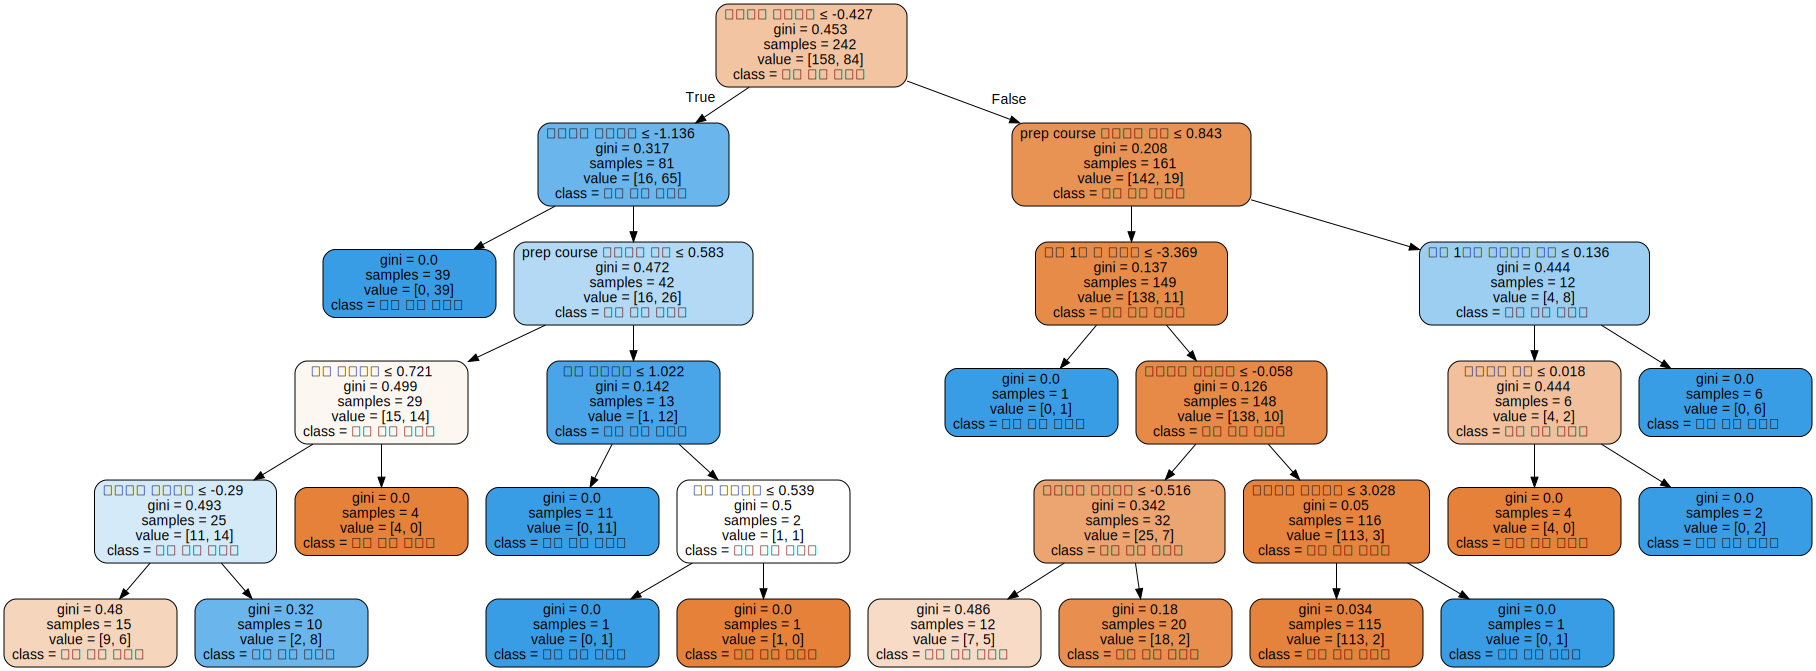

In [44]:
# 시각화
# 트리 모델로 분류한다. 
dot_data = tree.export_graphviz(decision_tree = model,
                                feature_names = df_x.columns,
                                class_names = df_y.columns,
                                filled = True, rounded = True,
                                special_characters = True)
graph = graphviz.Source(dot_data)
graph

In [ ]:
분류 1)
저소득층 학생비율이 -0.427 보다 작은가요?
1)예 
결과) 평균미만의 성적을 가진 학생 클래스가 나옴 
     prep course를 선행하는 학생의 분류가 나옴 
     인종별 분류) 흑인 학생중 우등생, 열등생으로 나뉨. 
     평균미만의 성적을 가진 아시아계 학생들의 비율이 도출됨, 25개의 샘플중 15개의 샘플만 평균초과 학생의 수를 보임 

분류 2)
저소득층 학생비율이 -0.427 보다 작은가요?
1)아니오
결과) 평균초과의 성적을 가진 학생 클래스가 나옴 
     prep course를 선행하는 학생의 비율분포가 나옴 
     교사와 교육예산에 관한 분류) 교사 1명당 담당 학생수, 학생 1명당 예산지출에 관한 분류
     차터스쿨(대안학교)에 다니는 학생들의 분포가 적을수록 평균 이상의 성적을 가진다는 분류가 나옴 6개의 샘플중 4개의 샘플이 우등생임
     교사1명당 학생수가 -3.369보다 작을수록 평균 초과 학생의 비율이 월등히 높음.
     인종병 분류에서 아시아계 학생들이 등장하는데 밑의 4개 분포를 보면 4개중 3개의 마지막 클래스가 아시아계 학생들로만 이루어진 샘플이라고 봤을때 모두 평균이상의 성적을 가진 우등생이다. 
     분류1 에서 왼쪽 맨 아래 분류 결과에서 아시아계 학생에 관한 분류가 등장하는데, 이 역시 평균이상의 성적을 가진 학생들이 최종 클래스에 해당된다. 
     
결론)
인종별 분류로는 2개의 인종(아시아계, 흑인계)으로만 분류했다. 아시아계 학생들이 대부분 우등성적을 가지고 있음을 보인다. 
차터스쿨에 다니는 학생수가 적을수록 우등생이라는 결론이 보인다. 